# Feature Extraction from Activity Recognition Time Series Data

## Exploratory Data Anlaysis
Source: [UCI HAR activity recognition data set](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)
The basic description about the dataset and the files are given in the *README.txt*

>The sensor signals (accelerometer and
gyroscope) were recorded with a sampling rate of 50 Hz and
pre-processed by applying noise filters and then sampled in fixed-width
sliding windows of 2.56 sec and 50\% overlap (128 readings/window).

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft
import seaborn

In [2]:
# Check size and records
X_train = pd.read_fwf('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True)
print(f'X_train: # rows: {X_train.shape[0]}, # columns: {X_train.shape[1]}')

X_train: # rows: 7351, # columns: 561
In X_train, each row is a training sample while each column is a feature.


In [3]:
# Read feature labels and add them to dataframe
with open('UCI HAR Dataset/features.txt') as f:
    names = [line.split()[1] for line in f.readlines()]

X_train.columns = names
print(f'The first 5 features are: {names[:5]}')

The first 5 features are: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y']


In [92]:
# Calculate basic statistics for each feature
first_ten_features = X_train.iloc[:,: 10] # only for the first 10 features
stat_frame = pd.DataFrame()
stat_frame.index.name = 'feature'
stat_frame['mean'] = first_ten_features.mean() # mean
stat_frame['std'] = first_ten_features.std() # standard deviation
stat_frame['q90'] = first_ten_features.quantile(0.90) # 90th percentile
stat_frame['q95'] = first_ten_features.quantile(0.95) # 95th percentile
stat_frame['q99'] = first_ten_features.quantile(0.99) # 99th percentile
print(stat_frame)

                       mean       std       q90       q95       q99
feature                                                            
tBodyAcc-mean()-X  0.274486  0.070266  0.337508  0.374711  0.445009
tBodyAcc-mean()-Y -0.017695  0.040813  0.004937  0.017750  0.067047
tBodyAcc-mean()-Z -0.109138  0.056638 -0.069992 -0.047511  0.036921
tBodyAcc-std()-X  -0.605385  0.448742  0.050146  0.204830  0.441481
tBodyAcc-std()-Y  -0.510873  0.502649  0.170763  0.292236  0.497143
tBodyAcc-std()-Z  -0.604712  0.418700 -0.024667  0.127426  0.460195
tBodyAcc-mad()-X  -0.630463  0.424080 -0.018159  0.146383  0.395803
tBodyAcc-mad()-Y  -0.526845  0.485946  0.133478  0.246683  0.442150
tBodyAcc-mad()-Z  -0.606107  0.414133 -0.023398  0.119572  0.420006
tBodyAcc-max()-X  -0.468541  0.544556  0.395629  0.530997  0.660661


In [5]:
# Analyse the labels
y_train = pd.read_fwf('UCI HAR Dataset/train/y_train.txt', delim_whitespace=True)
y_train = y_train.rename(columns={'5': 'class'})
print(f'y_train: # rows: {y_train.shape[0]}, # columns: {y_train.shape[1]}')
print(f'In y_train, each row is a label with the single column describing the label value. The values represent the 6 activities that were performed: 1 WALKING, 2 WALKING_UPSTAIRS, 3 WALKING_DOWNSTAIRS, 4 SITTING, 5 STANDING, 6 LAYING')

y_train: # rows: 7351, # columns: 1
In y_train, each row is a label with the single column describing the label value. The values represent the 6 activities that were performed: 1 WALKING, 2 WALKING_UPSTAIRS, 3 WALKING_DOWNSTAIRS, 4 SITTING, 5 STANDING, 6 LAYING


mean: 1225.1666666666667, std: 166.71822535843725


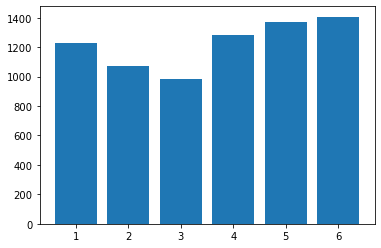

In [6]:
# Checking balance of data
y_train_grouped = y_train.groupby('class').size()
plt.bar(y_train_grouped.index, y_train_grouped)
print(f'mean: {y_train_grouped.mean()}, std: {y_train_grouped.std()}')
plt.show()

##### 4.3
Next, we want to compare the values and shapes of the features for every class. The features may look
different for different classes (a truck has 2 doors and a car 3 or more) and this corresponds to the idea that
we want to differentiate and classify whether a signal from this database comes from walking or standing
for example. To be able to do this, you need to couple the class labels (Y) with the feature data values (X).
You have inspected the dimensions of both which provides a clue about how this should be done.
To create distribution you can use the following:
• Features to Distribution: The [seaborn.kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) package in Python allows you to easily use Kernel Density Estimates (KDE) to turn the feature values into distributions.

### Exploring class patterns

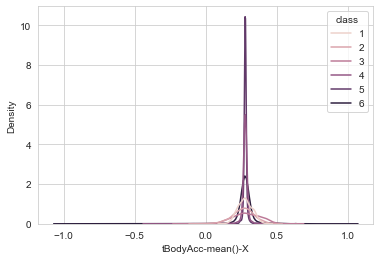

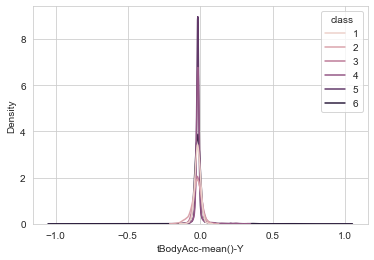

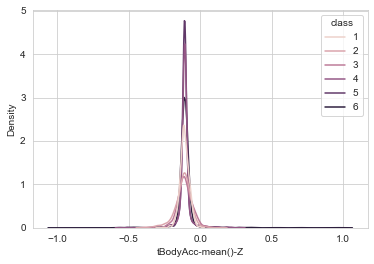

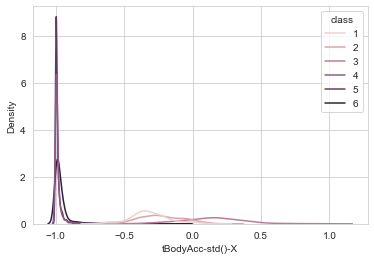

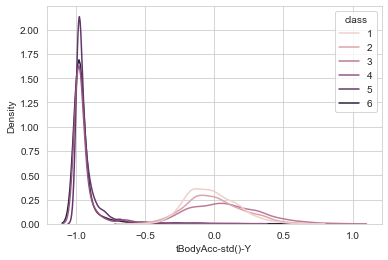

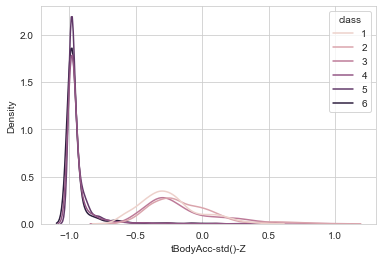

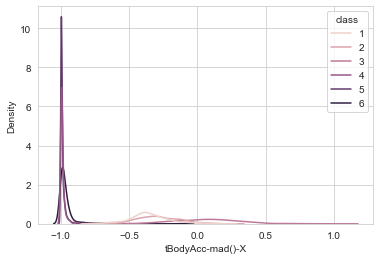

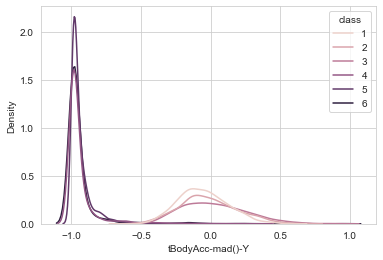

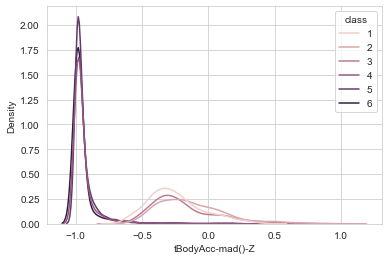

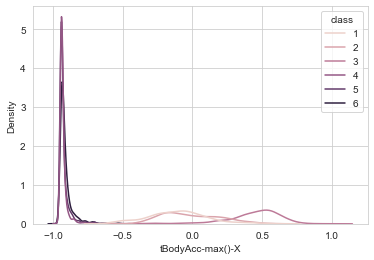

In [93]:
# Analyse the distribution of classes for each feature
comb = pd.concat([X_train, y_train], axis=1)
seaborn.set_style(style= 'whitegrid')
for column in comb.columns[:10]:
    p = seaborn.kdeplot(data = comb[[column ,'class']], x = column, hue = 'class')
    plt.show()

Observations: Classes 1,2 and 3 (walking activities) have
- higher variance in body acceleration means
- higher variance and different mean shifted to the left for the st.dev of body acceleration
- similar distribution as previous point for the mean absolute deviation and the max acceleration

Classes 4,5 and 6 (standing or laying activities) have
- overall smaller variance
- the mean of the max, mean absolute deviation and st.dev of the body acceleration shifted to the left (negative values)

> Distinguishing pattern between activities with and without the involvement of motion

### Exploring the Raw Data

In [8]:
ax1 = pd.read_fwf('UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt')
ax2 = pd.read_fwf('UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt')
ax3 = pd.read_fwf('UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt')

print(f'Axis 1: {ax1.shape}')
print(f'Axis 2: {ax2.shape}')
print(f'Axis 3: {ax3.shape}')

Axis 1: (7351, 128)
Axis 2: (7351, 128)
Axis 3: (7351, 128)


Variances: Axis 1: 0.17129961061363466,Axis 2: 0.15287977947851675,Axis 3: 0.1278100738183289


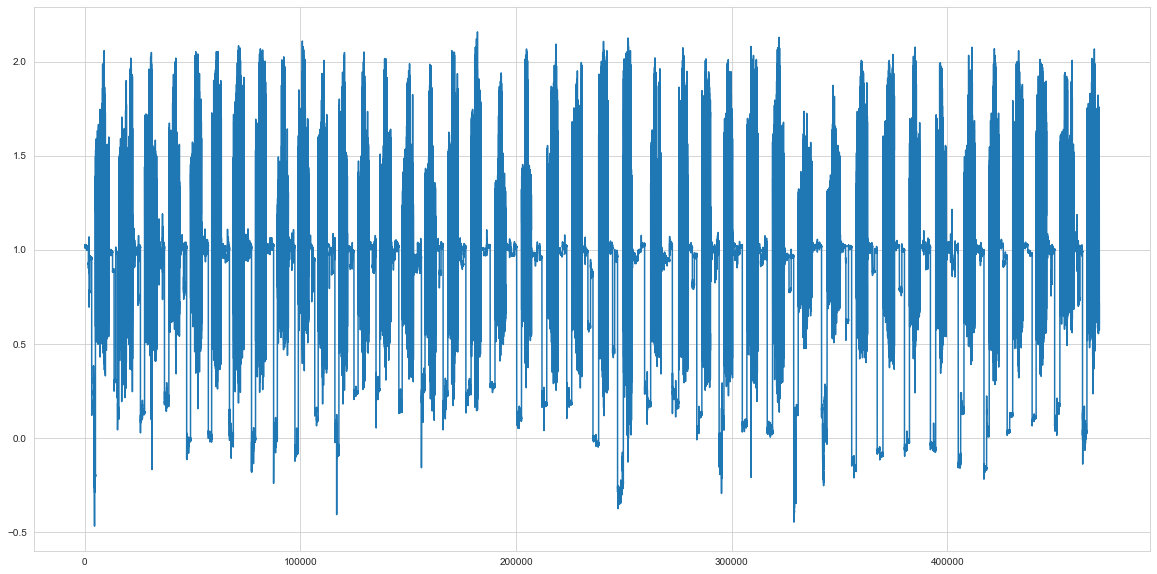

In [9]:
# Remove last half of every row to delete overlap
ax1_window = ax1.iloc[:,:64]
ax2_window = ax2.iloc[:,:64]
ax3_window = ax3.iloc[:,:64]

# Also add the last part of the last row
ax1_window.append(ax1.iloc[-1,64:])
ax2_window.append(ax2.iloc[-1,64:])
ax3_window.append(ax3.iloc[-1,64:])

# Concatenate labels and data
ax1_comb = pd.concat([ax1_window, y_train], axis=1)
ax2_comb = pd.concat([ax2_window, y_train], axis=1)
ax3_comb = pd.concat([ax3_window, y_train], axis=1)

def create_raw_signal(data):
    # keep the class as index, stack other columns below each other
    stacked = data.set_index('class').stack()
    
    # set the name of the new series created
    data_stacked = stacked.reset_index(name='signal_values')

    # drop the 'source' level column (key.*)
    data_stacked.drop('level_1', axis=1, inplace=True)

    return data_stacked

def create_raw_signal_explode(data):
    data = data.set_index('class').apply(lambda row: [x for x in row], axis = 1)
    data_exploded = data.reset_index('class').explode(0)
    data_exploded.columns = ['class', 'signal_values']
    return data_exploded

ax1_stacked = create_raw_signal(ax1_comb)
ax2_stacked = create_raw_signal(ax2_comb)
ax3_stacked = create_raw_signal(ax3_comb)
ax1_exploded = create_raw_signal_explode(ax1_comb)

# Get the raw signal from one axis and plot it
raw_signal = ax1_stacked['signal_values']
raw_signal2 = ax2_stacked['signal_values']
raw_signal3 = ax3_stacked['signal_values']
print(f'Variances: Axis 1: {raw_signal.var()},Axis 2: {raw_signal2.var()},Axis 3: {raw_signal3.var()}')

# Plot an example
fig, ax = plt.subplots(1,1, figsize = (20,10))
ax.plot(raw_signal)

In [10]:
def get_statistics(raw_signal):
    print(f'Mean: {raw_signal.mean()}')
    print(f'St.dev: {raw_signal.std()}')
    print(f'Skewness: {raw_signal.skew()}')
    print(f'Kurtosis: {raw_signal.kurtosis()}')

get_statistics(raw_signal)

Mean: 0.8049102267183695
St.dev: 0.4138835713260852
Skewness: -0.72734260336599
Kurtosis: 0.17654975846468846


signal_values                                                    \
              count      mean       std       min       25%       50%   
class                                                                   
1           78464.0  0.995446  0.230312  0.194583  0.824816  0.969453   
2           68672.0  0.950465  0.263176  0.095020  0.760901  0.923336   
3           63104.0  0.990789  0.376459 -0.207860  0.722909  0.889466   
4           82304.0  0.951156  0.104158  0.427836  0.929261  0.989242   
5           87872.0  1.001416  0.025654  0.640800  0.989871  1.010083   
6           90048.0  0.072195  0.141256 -0.466556 -0.019606  0.084081   

                           
            75%       max  
class                      
1      1.156761  2.045333  
2      1.103257  2.002134  
3      1.223115  2.157473  
4      1.016088  1.191525  
5      1.019428  1.227342  
6      0.184280  0.475669

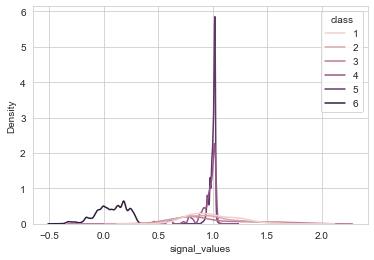

In [11]:
seaborn.kdeplot(data = ax1_stacked, x = 'signal_values', hue = 'class' )
ax1_stacked.groupby(['class']).describe()

## Preprocessing
## Create the fourier transformation
Goal: Analyse possible feature distinctions in the frequency domain

Inspiration: [Python Implementation](https://github.com/nipunbatra/ProgramaticallyUnderstandingSeries/blob/master/ft.ipynb) and [Theory](https://www-dawsonera-com.ezproxy2.utwente.nl/readonline/9781292037936)



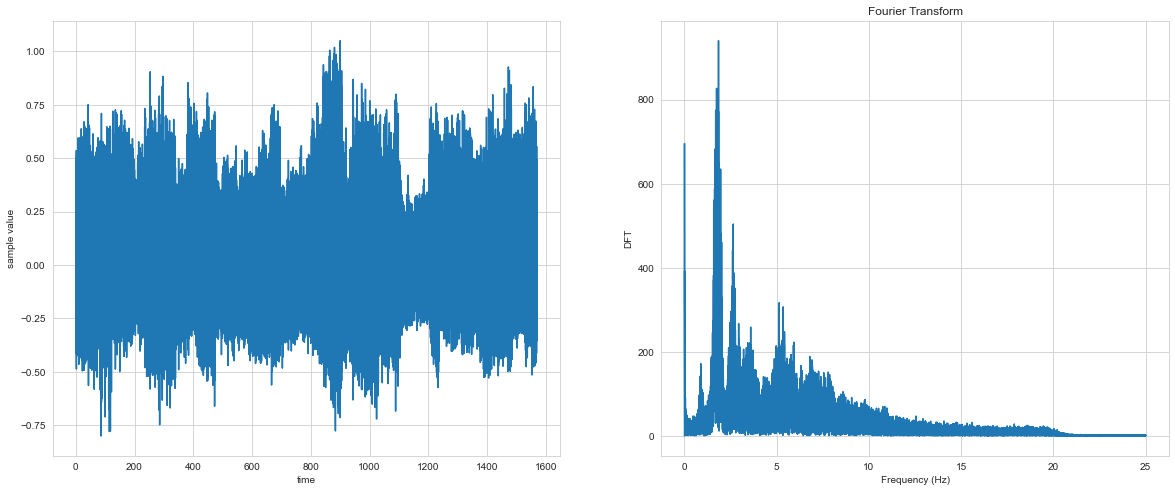

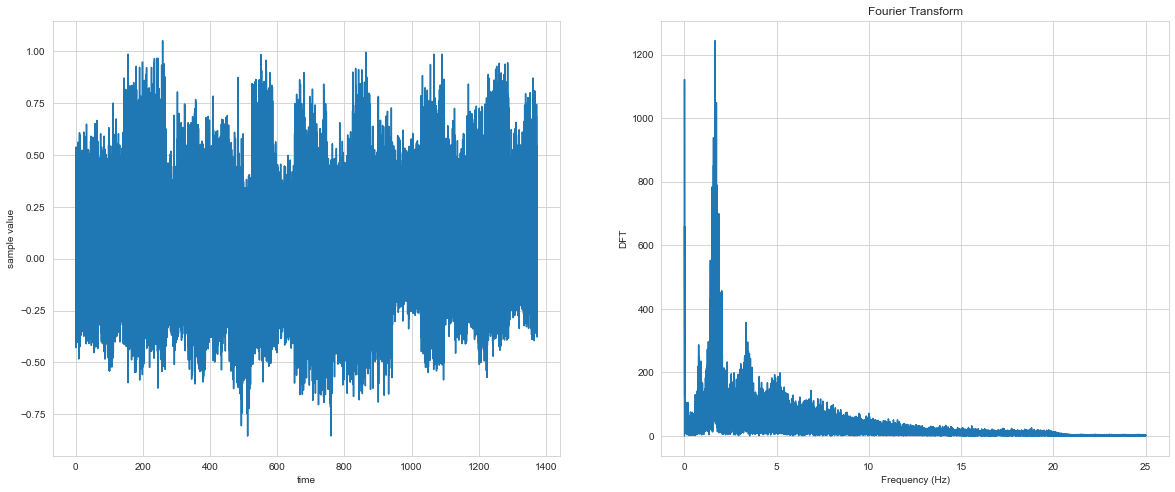

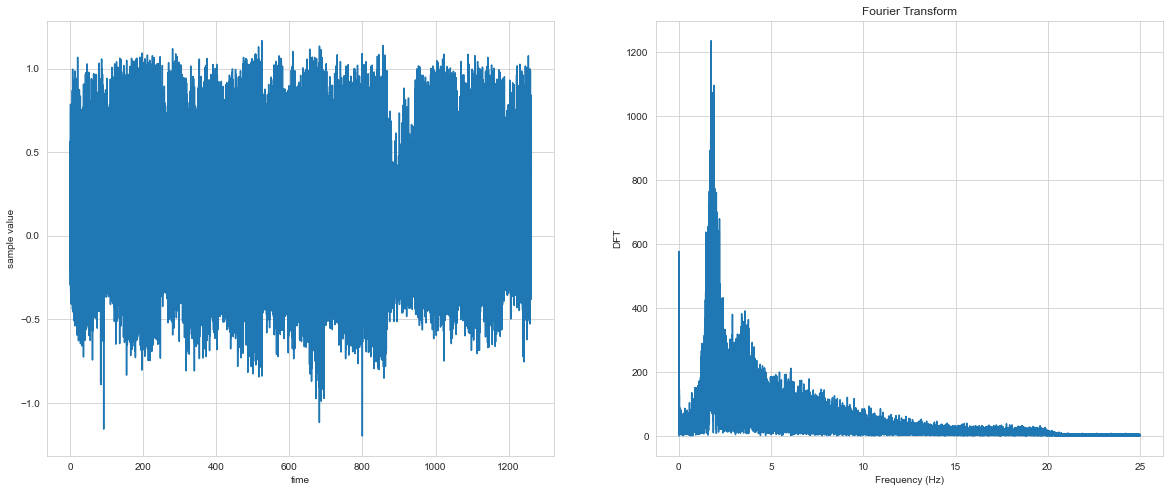

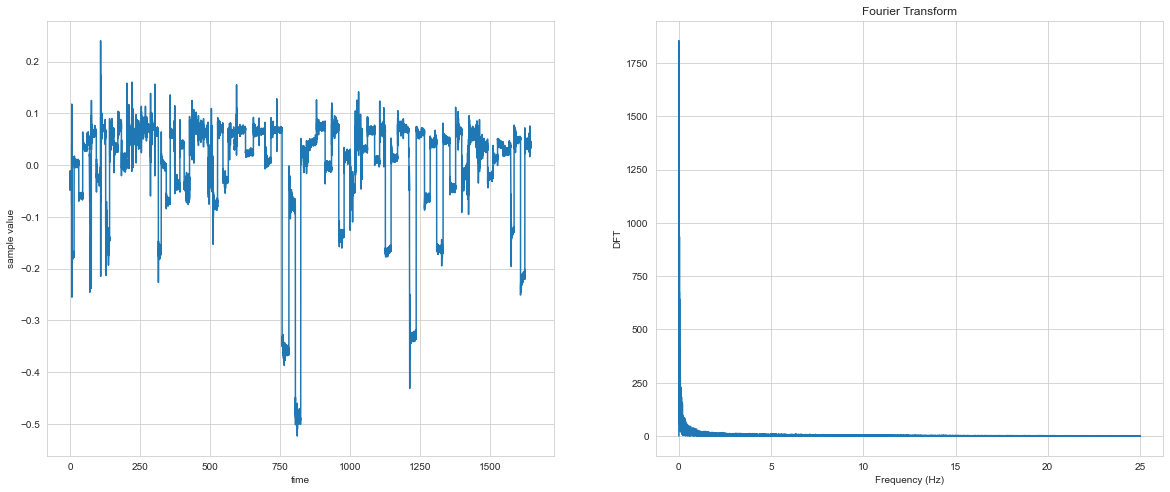

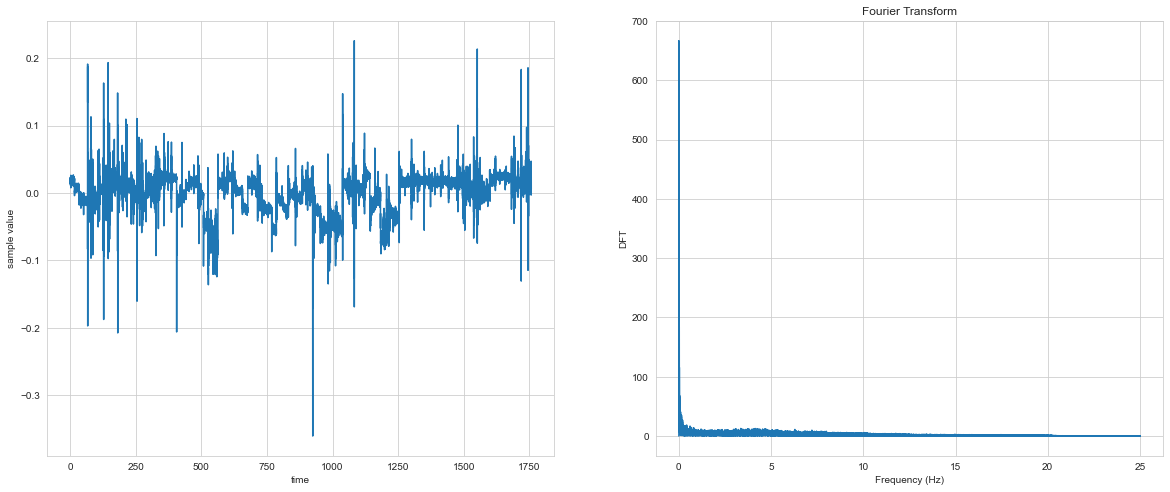

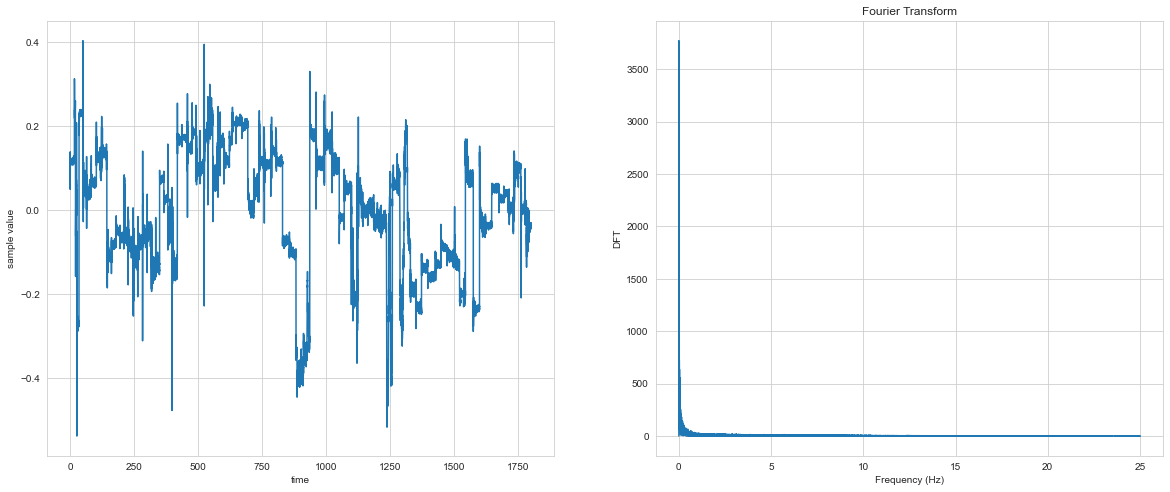

In [12]:
import scipy.fft

def create_fourier_transform(raw_signal, title):
    # Raw signal data + removing offset
    s = raw_signal['signal_values'].to_numpy()
    s = s - np.mean(s)

    # Number of samples
    N = len(s)
    # Sampling frequency in herz (samples/second)
    H = 50
    # Time range in seconds, test function (end = Number of samples * (second/samples) = seconds)
    t = np.linspace(0.0, N*(1/H), N, endpoint=True)
    #s = np.sin(2 * 2 * np.pi * t) + 0.8 * np.sin(4 * 2 * np.pi  * t) + 0.5 * np.sin(6 * 2 * np.pi * t) -> test function

    # Do Fourier Transform
    Y = scipy.fft.fft(s)
    # create frequency axis (points = half of the fourier transform, end = half of max sampling frequency -> Nyquist frequency)
    x_freq = np.linspace(0.0, H/2, N//2)

    # Plot
    fig, ax = plt.subplots(1,2, figsize = (20,8))
    ax[0].plot(t, s)
    ax[0].set_xlabel('time')
    ax[0].set_ylabel('sample value')
    ax[1].set_title(title)
    ax[1].plot(x_freq, np.abs(Y[:len(s)//2]))
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('DFT')

for i in range(1,7):
    create_fourier_transform(ax1_stacked[ax1_stacked['class'] == i], title = 'Fourier Transform')

### Filtering

Exploring low-pass, high-pass and band-pass filtering to enable clear distinction between classes.

In [ ]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='lowpass', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data, axis=0)
    data = pd.DataFrame()
    data['signal_values'] = y.T[1]
    return data

def butter_highpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='highpass', analog=False)

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data, axis=0)
    data = pd.DataFrame()
    data['signal_values'] = y.T[1]
    return data

def butter_bandpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='bandpass', analog=False)

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = lfilter(b, a, data, axis=0)
    data = pd.DataFrame()
    data['signal_values'] = y.T[1]
    return data

The settings used are : Order = 3, fs = 50, cutoff = 0.5 and 5. The bandpass filtering was the best performing one as we have noise on both the low and high frequecny range. 


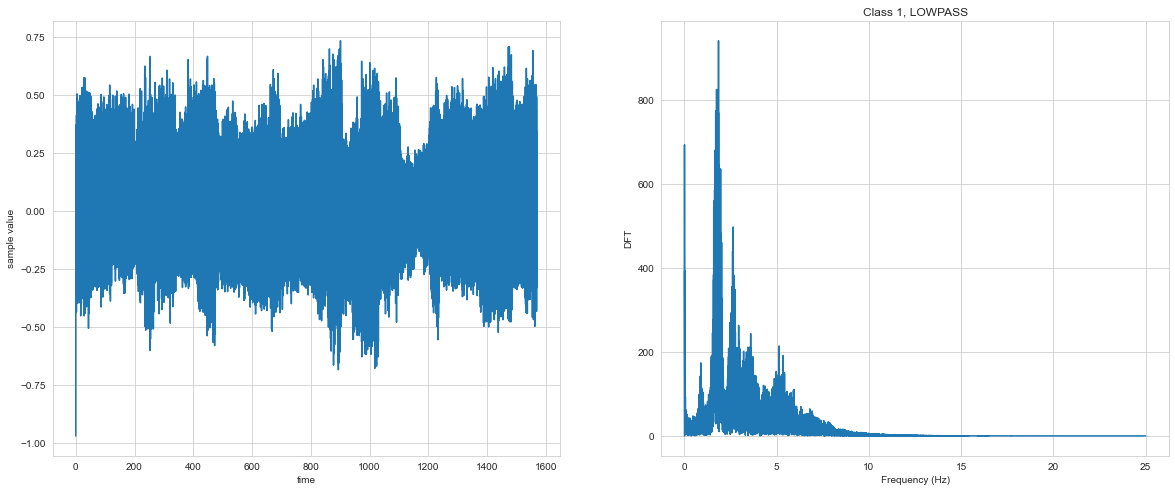

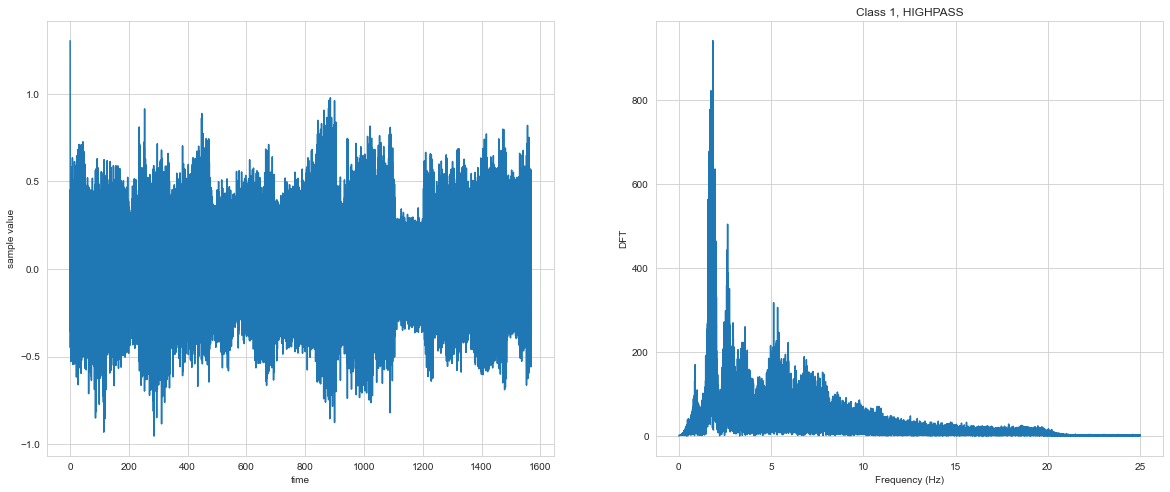

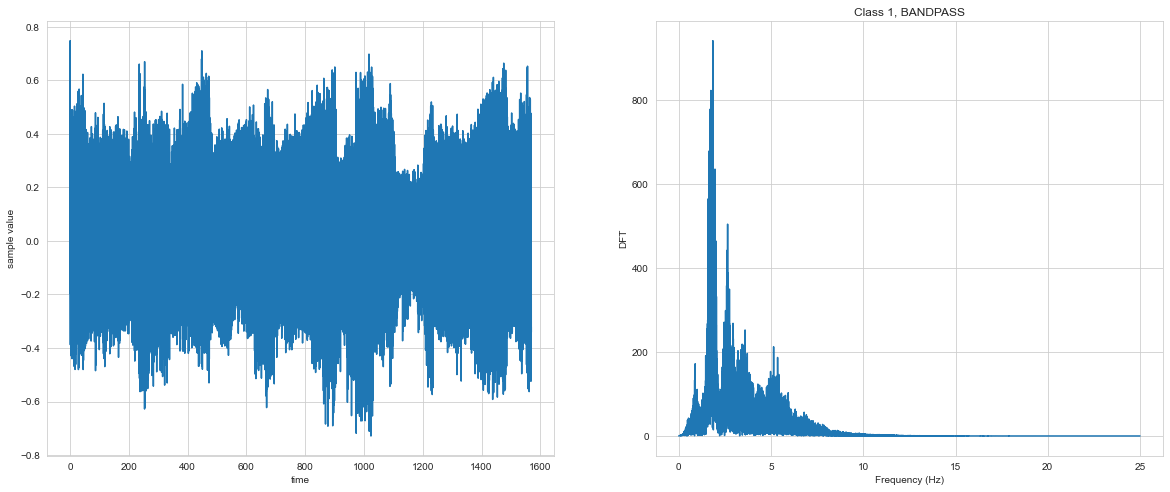

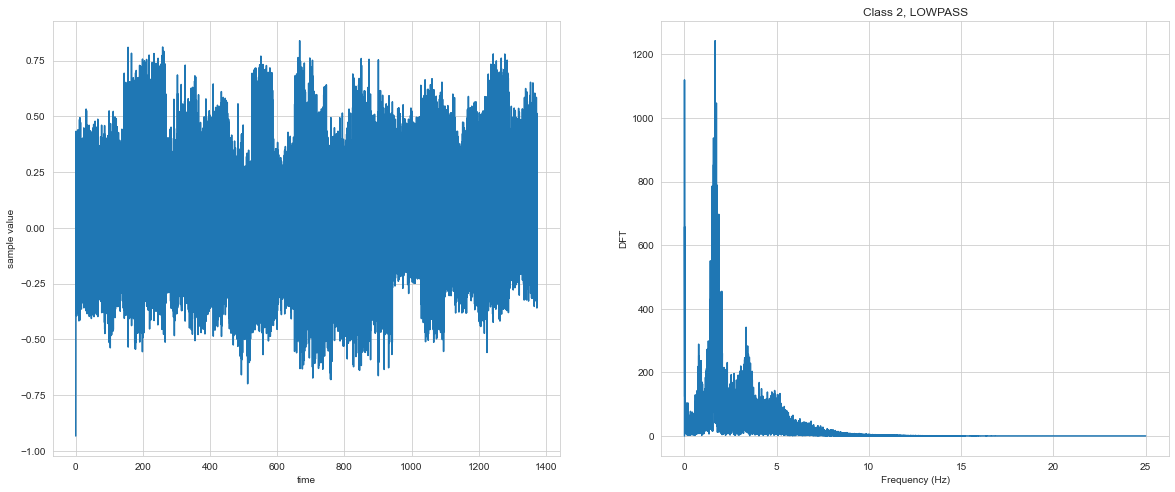

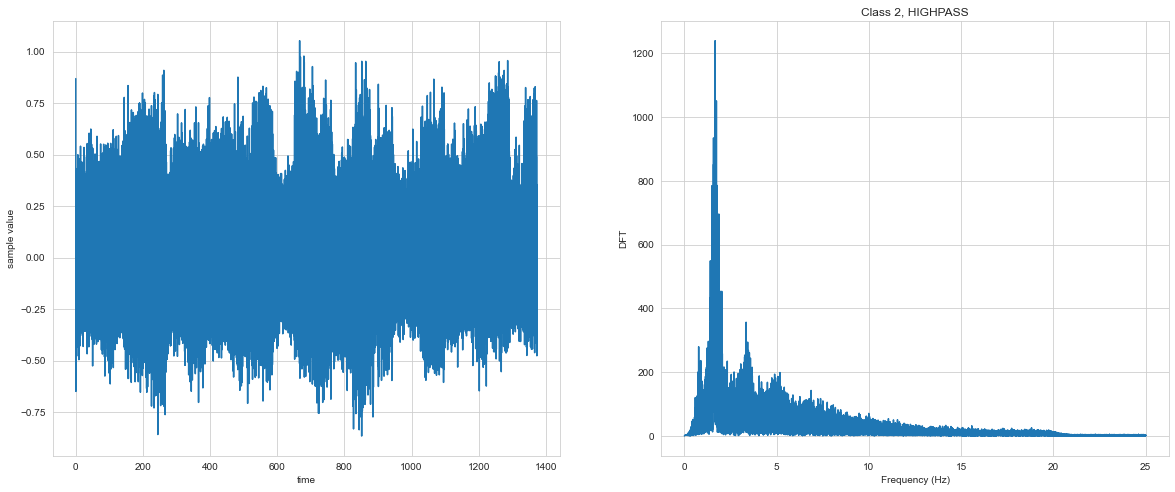

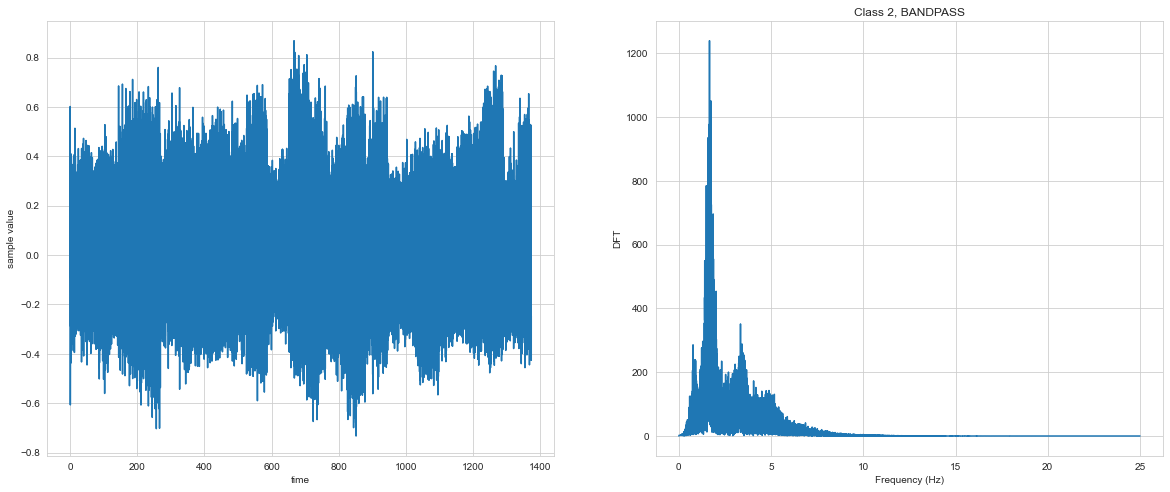

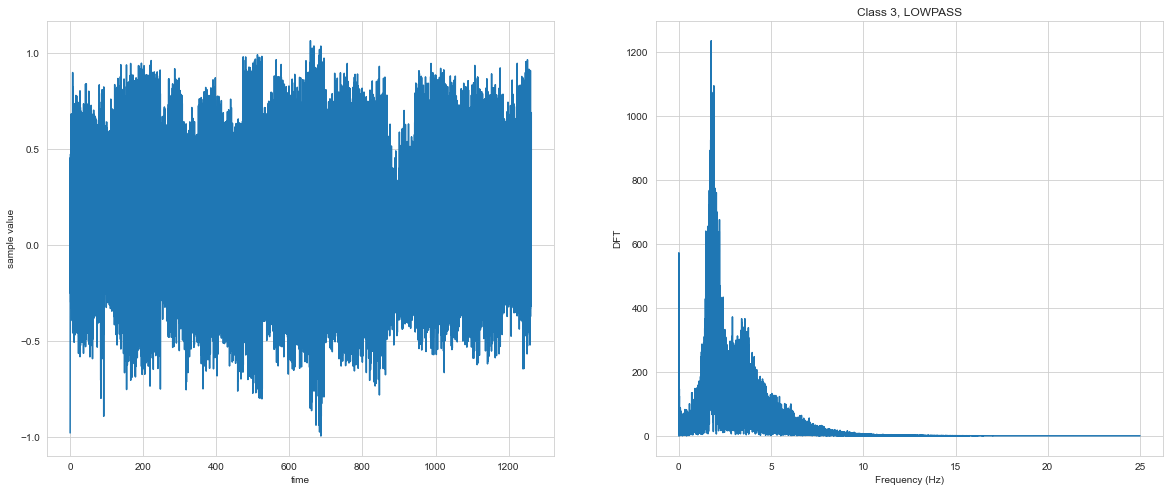

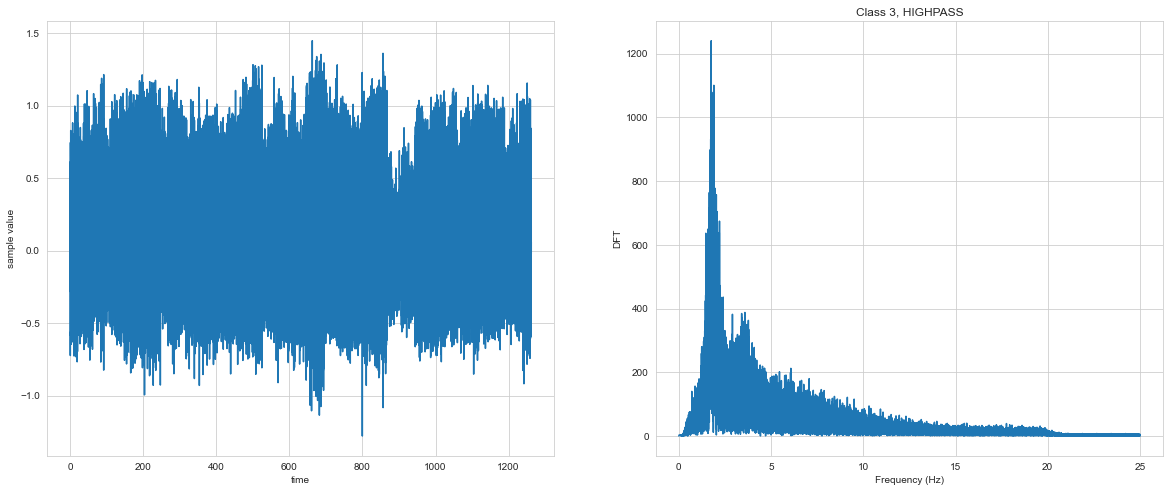

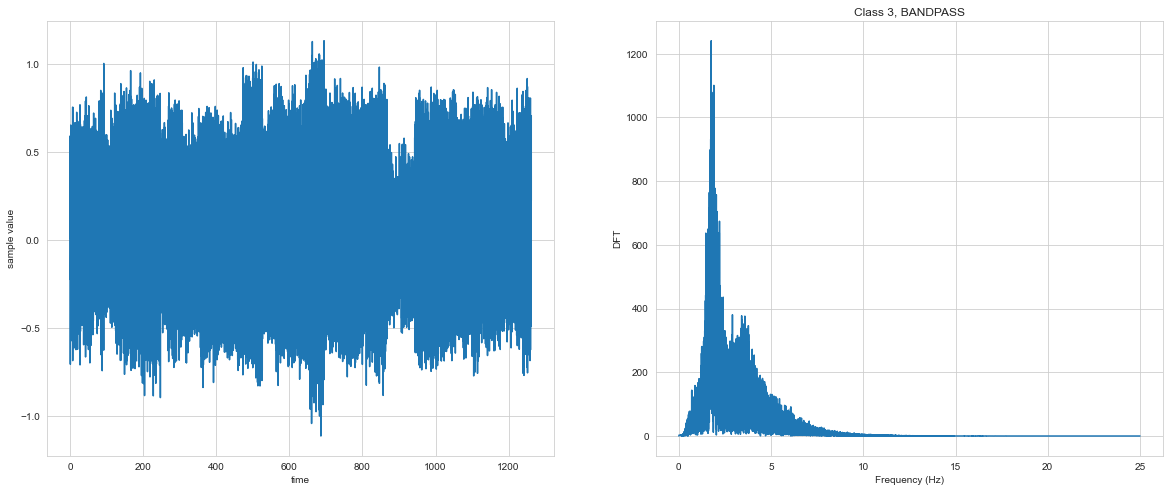

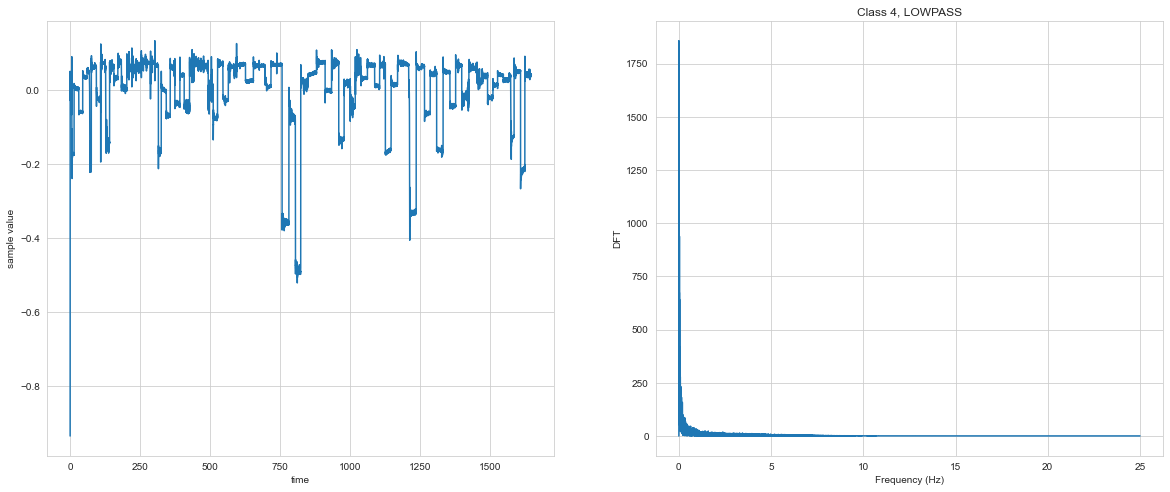

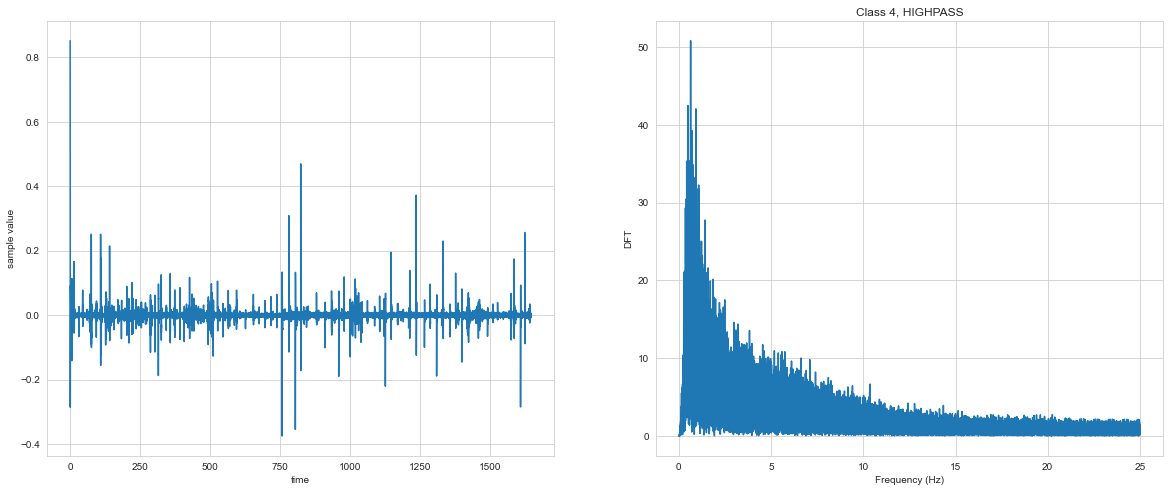

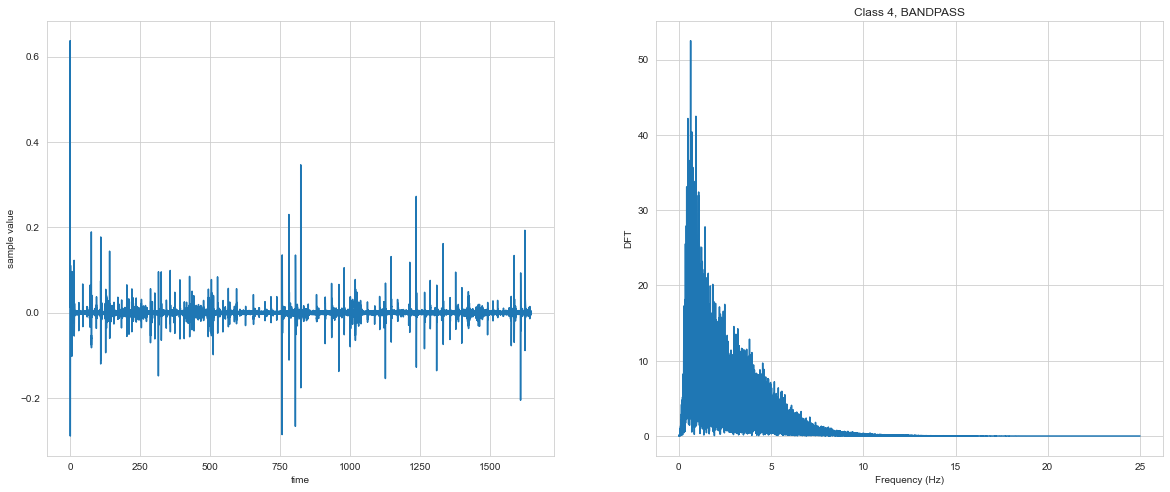

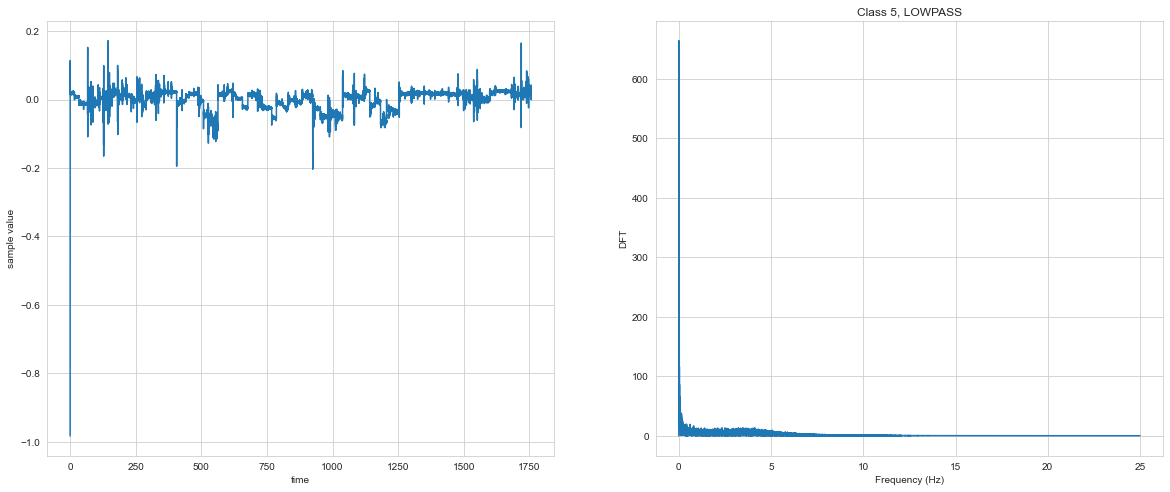

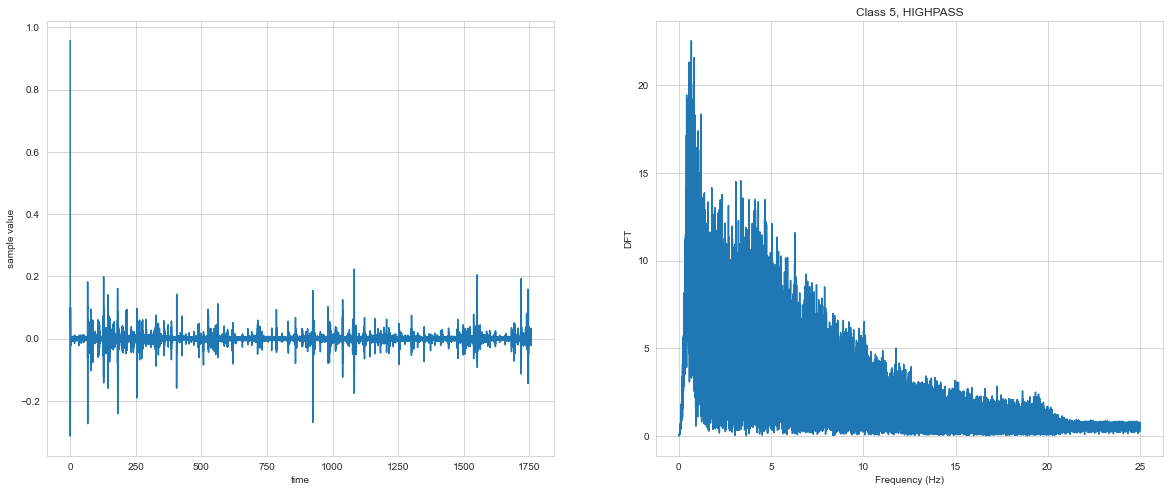

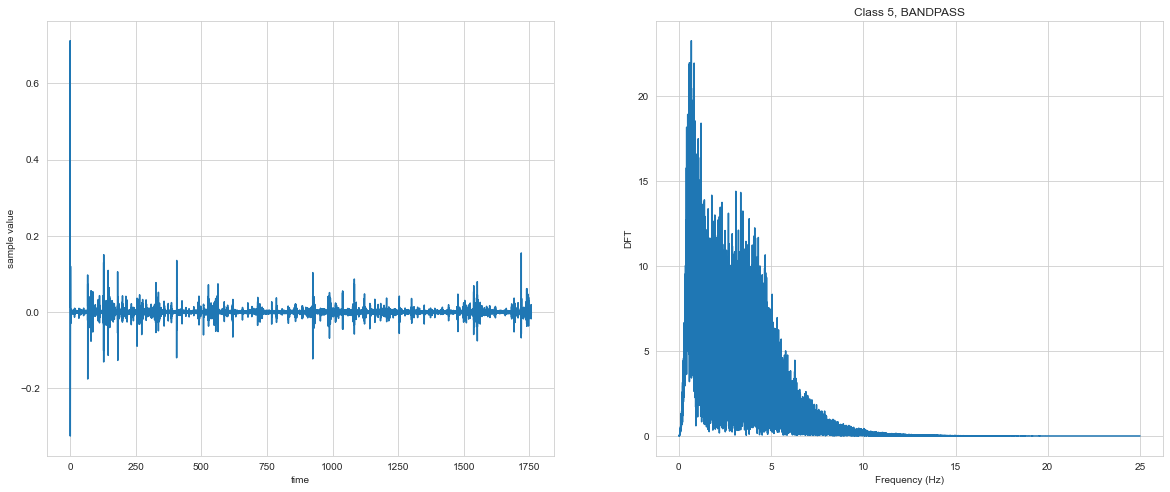

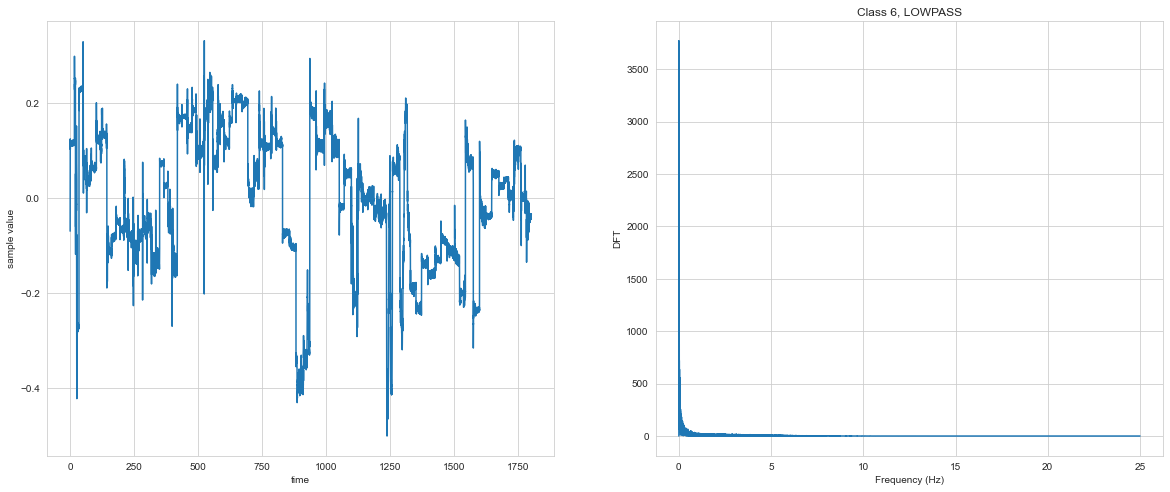

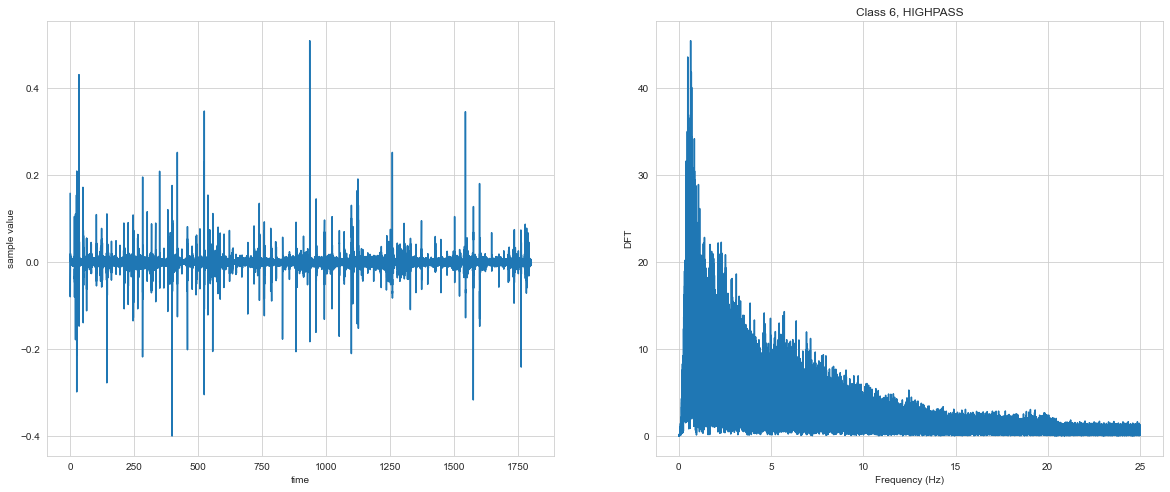

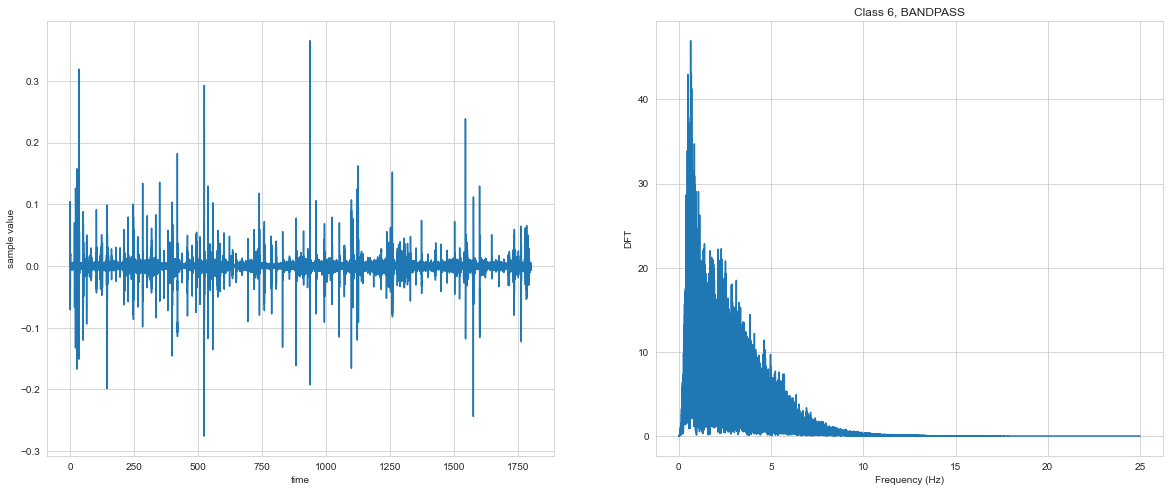

In [94]:
# Filter requirements.
order = 3
fs = 50.0       # sample rate, Hz
cutoff = 5.0  # desired cutoff frequency of the filter, Hz

# Generate the time vector properly
for i in range(1,7):
    # Filter the data, and plot both the original and filtered signals.
    data = ax1_stacked[ax1_stacked['class'] == i]
    create_fourier_transform(butter_lowpass_filter(data, 5.0, fs, order), title=f'Class {i}, LOWPASS')
    create_fourier_transform(butter_highpass_filter(data, 0.5, fs, order), title=f'Class {i}, HIGHPASS')
    create_fourier_transform(butter_bandpass_filter(data, [0.5,5], fs, order), title=f'Class {i}, BANDPASS')

print(f'The settings used are : Order = 3, fs = 50, cutoff = 0.5 and 5. The bandpass filtering was the best performing one as we have noise on both the low and high frequecny range. ')

## Classification
### Dynamic Time Warping and Classification with K-nearest Neighbours

The K-nearest Neighbour classfier is used to classify the 6 different classes based on the raw and feature data using Dynamic Time Warping as the distance measure.
Sources:

 [Python tutorial on DTW and KNN classification](https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb)
 [Explanation of DTW presented by Thales Sehn Korting](https://www.youtube.com/watch?v=_K1OsqCicBY)
 [Practical approach to the DTW algorithm in Python](https://github.com/nipunbatra/ProgramaticallyUnderstandingSeries/blob/master/dtw.ipynb)


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import seaborn
import statistics
import sys, time
import collections
import itertools
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.stats import mode
from scipy.spatial.distance import squareform
from tqdm import tqdm
#Given functions from the tutorial
try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
    Number of neighbors to use by default for KNN
    max_warping_window : int, optional (default = infinity)
    Maximum warping window allowed by the DTW dynamicprogramming function
    subsample_step : int, optional (default = 1)
    Step size for the timeseries array. By setting subsample_step = 2,
    the timeseries length will be reduced by 50% because every second
    item is skipped. Implemented by x[:, ::subsample_step]
    """
    def __init__(self, n_neighbors=5, max_warping_window=10000,subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        Training data set for input into KNN classifer
        l : array of shape [n_samples]
        Training labels for input into KNN classifier
        """
        self.x = x
        self.l = l
    def _dtw_distance(self, ts_a, ts_b, d=lambda x, y: abs(x - y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.
        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
        Two arrays containing n_samples of timeseries data
        whose DTW distance between each sample of A and B
        will be compared
        d : DistanceMetric object (default = abs(x-y))
        the distance measure used for A_i - B_j in the
        DTW dynamic programming function
        Returns
        -------
        DTW distance between A and B"""
    #      Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = float('inf') * np.ones((M, N))
        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i - 1, 0] + d(ts_a[i], ts_b[0])
        for j in range(1, N):
            cost[0, j] = cost[0, j - 1] + d(ts_a[0], ts_b[j])
        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j - 1], cost[i - 1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])
            # Return DTW distance given window
        return cost[-1, -1]

    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        y : array of shape [n_samples, n_timepoints]
        Returns
        -------
        Distance matrix between each item of x and y with
        shape [training_n_samples, testing_n_samples]
        """
        # Compute the distance matrix
        dm_count = 0
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if (np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            p = ProgressBar(shape(dm)[0])
            for i in tqdm(xrange(0, x_s[0] - 1)): #tqdm for progress bar
                for j in xrange(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],y[j, ::self.subsample_step])
                    dm_count += 1
#                     p.animate(dm_count) # progressbar was being used here
                    # Convert to squareform
                    dm = squareform(dm)
            return dm
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0]))
            dm_size = x_s[0] * y_s[0]
            p = ProgressBar(dm_size)
            for i in tqdm(range(0, x_s[0])): #tqdm is used to print the progress
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
#                     p.animate(dm_count) # progressbar was being used here
            return dm
   
    def predict(self, x):
        """Predict the class labels or probability estimates for
        the provided data
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        Array containing the testing data set to be classified
        4
        Returns
        -------
        2 arrays representing:
        (1) the predicted class labels
        (2) the knn label count probability"""
        dm = self._dist_matrix(x, self.x)
        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]
        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1] / self.n_neighbors
        return mode_label.ravel(), mode_proba.ravel()

#Progressbar is not used because of a bug which prints the progress in next line. 
class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 50
        self.__update_amount(0)

    def animate(self, iter):
        print('\r', self, end='')
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

succesfull load


100%|██████████| 295/295 [1:06:04<00:00, 13.44s/it]


                    precision    recall  f1-score   support

           WALKING       0.96      0.80      0.87        60
  WALKING UPSTAIRS       0.85      0.80      0.83        51
WALKING DOWNSTAIRS       0.68      0.97      0.80        31
           SITTING       0.78      0.78      0.78        51
          STANDING       0.84      0.76      0.80        55
            LAYING       0.90      1.00      0.95        47

          accuracy                           0.84       295
         macro avg       0.84      0.85      0.84       295
      weighted avg       0.85      0.84      0.84       295

succesfull load


100%|██████████| 295/295 [13:47<00:00,  2.80s/it]


                    precision    recall  f1-score   support

           WALKING       0.94      0.89      0.91        53
  WALKING UPSTAIRS       0.85      0.67      0.75        61
WALKING DOWNSTAIRS       0.59      0.93      0.72        28
           SITTING       0.37      0.38      0.38        50
          STANDING       0.38      0.35      0.36        55
            LAYING       0.50      0.54      0.52        48

          accuracy                           0.60       295
         macro avg       0.61      0.63      0.61       295
      weighted avg       0.62      0.60      0.60       295

succesfull load


100%|██████████| 295/295 [13:46<00:00,  2.80s/it]


                    precision    recall  f1-score   support

           WALKING       0.90      0.88      0.89        51
  WALKING UPSTAIRS       0.75      0.64      0.69        56
WALKING DOWNSTAIRS       0.52      0.74      0.61        31
           SITTING       0.43      0.56      0.49        39
          STANDING       0.50      0.52      0.51        48
            LAYING       0.56      0.41      0.48        70

          accuracy                           0.61       295
         macro avg       0.61      0.63      0.61       295
      weighted avg       0.62      0.61      0.61       295

succesfull load


100%|██████████| 295/295 [13:36<00:00,  2.77s/it]


                    precision    recall  f1-score   support

           WALKING       0.92      0.77      0.84        60
  WALKING UPSTAIRS       0.73      0.69      0.71        51
WALKING DOWNSTAIRS       0.68      0.97      0.80        31
           SITTING       0.51      0.55      0.53        47
          STANDING       0.58      0.54      0.56        54
            LAYING       1.00      1.00      1.00        52

          accuracy                           0.74       295
         macro avg       0.74      0.75      0.74       295
      weighted avg       0.75      0.74      0.74       295

succesfull load


100%|██████████| 295/295 [13:19<00:00,  2.71s/it]


                    precision    recall  f1-score   support

           WALKING       0.90      0.69      0.78        65
  WALKING UPSTAIRS       0.83      0.78      0.81        51
WALKING DOWNSTAIRS       0.48      0.84      0.61        25
           SITTING       0.39      0.36      0.37        56
          STANDING       0.36      0.45      0.40        40
            LAYING       0.52      0.47      0.49        58

          accuracy                           0.58       295
         macro avg       0.58      0.60      0.58       295
      weighted avg       0.61      0.58      0.59       295

succesfull load


100%|██████████| 295/295 [13:45<00:00,  2.80s/it]


                    precision    recall  f1-score   support

           WALKING       0.86      0.59      0.70        73
  WALKING UPSTAIRS       0.52      0.71      0.60        35
WALKING DOWNSTAIRS       0.52      0.72      0.61        32
           SITTING       0.33      0.34      0.34        50
          STANDING       0.30      0.29      0.30        51
            LAYING       0.42      0.41      0.42        54

          accuracy                           0.49       295
         macro avg       0.49      0.51      0.49       295
      weighted avg       0.52      0.49      0.49       295

succesfull load


100%|██████████| 295/295 [13:31<00:00,  2.75s/it]


                    precision    recall  f1-score   support

           WALKING       0.70      0.66      0.68        53
  WALKING UPSTAIRS       0.83      0.73      0.78        55
WALKING DOWNSTAIRS       0.52      0.72      0.61        32
           SITTING       0.69      0.66      0.67        53
          STANDING       0.64      0.74      0.69        43
            LAYING       0.85      0.75      0.79        59

          accuracy                           0.71       295
         macro avg       0.70      0.71      0.70       295
      weighted avg       0.72      0.71      0.71       295

succesfull load


100%|██████████| 295/295 [13:23<00:00,  2.72s/it]


                    precision    recall  f1-score   support

           WALKING       0.72      0.57      0.64        63
  WALKING UPSTAIRS       0.77      0.76      0.76        49
WALKING DOWNSTAIRS       0.48      0.70      0.57        30
           SITTING       0.22      0.25      0.23        44
          STANDING       0.26      0.29      0.27        45
            LAYING       0.54      0.44      0.48        64

          accuracy                           0.49       295
         macro avg       0.50      0.50      0.49       295
      weighted avg       0.52      0.49      0.50       295

succesfull load


100%|██████████| 295/295 [13:28<00:00,  2.74s/it]


                    precision    recall  f1-score   support

           WALKING       0.86      0.52      0.65        83
  WALKING UPSTAIRS       0.62      0.77      0.69        39
WALKING DOWNSTAIRS       0.39      0.89      0.54        19
           SITTING       0.29      0.34      0.32        44
          STANDING       0.38      0.42      0.40        45
            LAYING       0.60      0.48      0.53        65

          accuracy                           0.53       295
         macro avg       0.52      0.57      0.52       295
      weighted avg       0.58      0.53      0.53       295

succesfull load


100%|██████████| 295/295 [13:21<00:00,  2.72s/it]


                    precision    recall  f1-score   support

           WALKING       0.78      0.58      0.67        67
  WALKING UPSTAIRS       0.73      0.76      0.74        46
WALKING DOWNSTAIRS       0.52      0.82      0.64        28
           SITTING       0.51      0.44      0.47        59
          STANDING       0.58      0.58      0.58        50
            LAYING       0.65      0.76      0.70        45

          accuracy                           0.63       295
         macro avg       0.63      0.66      0.63       295
      weighted avg       0.64      0.63      0.63       295



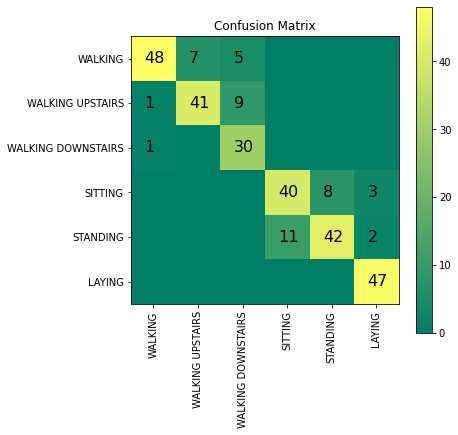

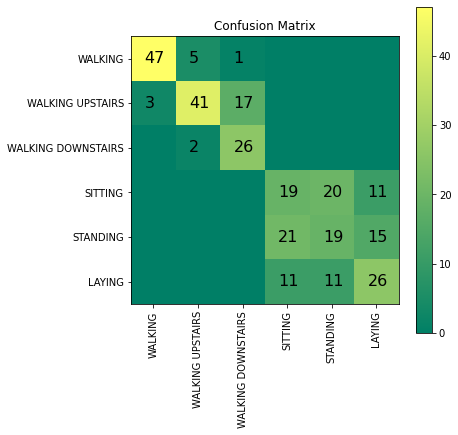

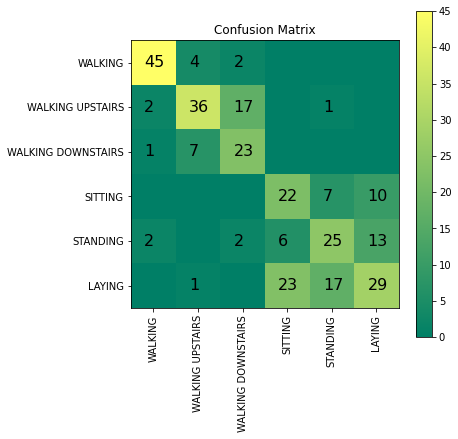

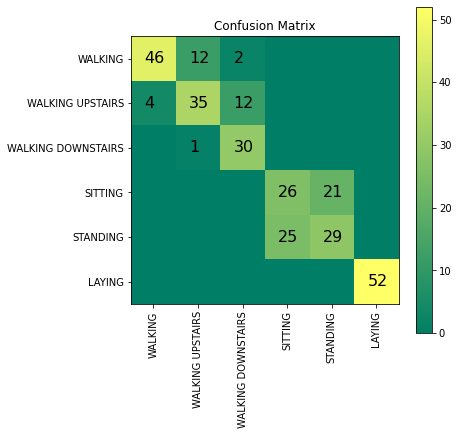

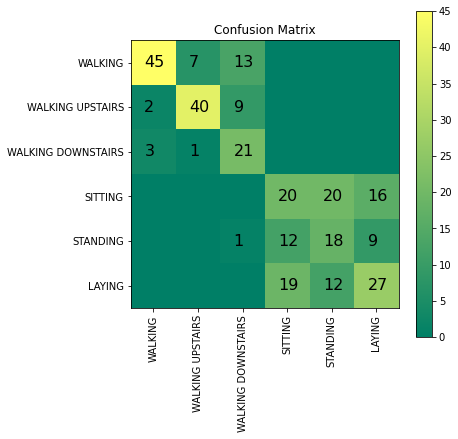

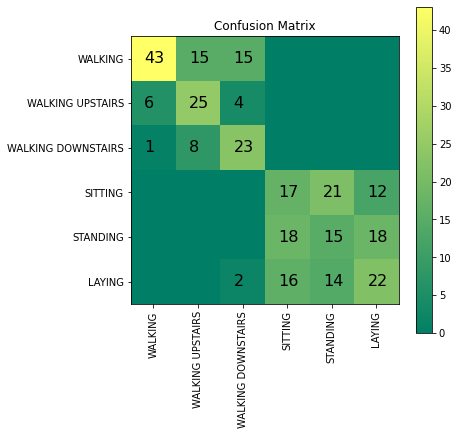

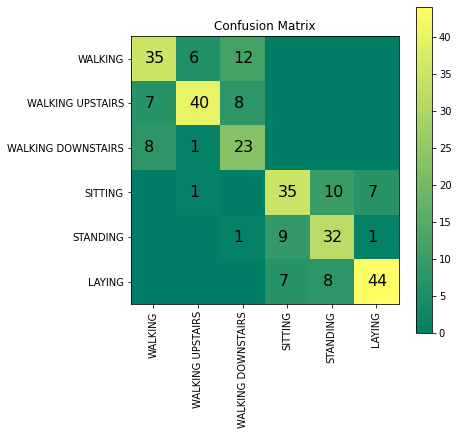

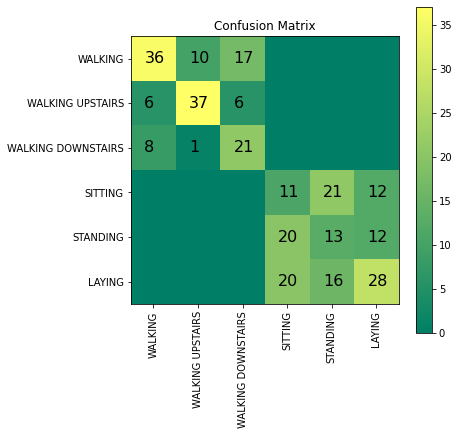

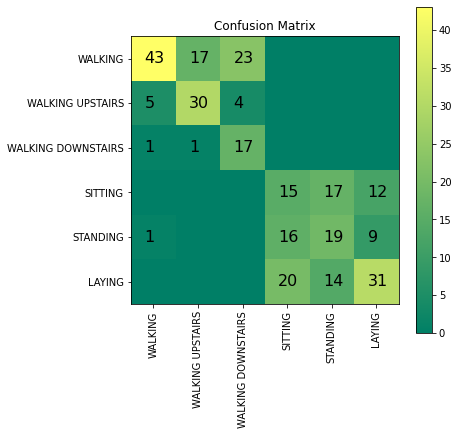

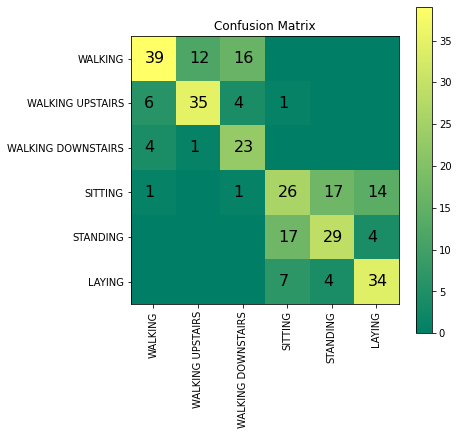

In [2]:
from sklearn.metrics import classification_report, confusion_matrix

def apply_dtw(get_x_file):
    x_train_file = get_x_file('train')
    y_train_file = get_y_file('train')
    x_test_file = get_x_file('test')
    y_test_file = get_y_file('test')
    # Create empty lists
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    # Mapping table for classes
    labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
              4:'SITTING', 5:'STANDING', 6:'LAYING'}

    # Loop through datasets
    for x in x_train_file:
        x_train.append([float(ts) for ts in x.split()])

    for y in y_train_file:
        y_train.append(int(y.rstrip('\n')))

    for x in x_test_file:
        x_test.append([float(ts) for ts in x.split()])

    for y in y_test_file:
        y_test.append(int(y.rstrip('\n')))
    print('succesful load')

    # Convert to numpy
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # Apply classification
    m = KnnDtw(n_neighbors=1, max_warping_window=10)
    m.fit(x_train[::10], y_train[::10])
    label, proba = m.predict(x_test[::10])

    # Show performance measures
    print (classification_report(label, y_test[::10], target_names=[l for l in labels.values()]))
    conf_mat = confusion_matrix(label, y_test[::10])

    # Plot confusion matrix
    fig = plt.figure(figsize=(6,6))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if c>0:
                plt.text(j-.2, i+.1, c, fontsize=16)

    cb = fig.colorbar(res)
    plt.title('Confusion Matrix')
    _ = plt.xticks(range(6), [l for l in labels.values()], rotation=90)
    _ = plt.yticks(range(6), [l for l in labels.values()])

# Apply classification to raw data
path = 'UCI HAR Dataset/'
get_y_file = lambda traintest: open(f'{path}{traintest}/y_{traintest}.txt')

apply_dtw(lambda traintest: open(f'{path}{traintest}/X_{traintest}.txt','r'))
for xyz in ['x','y','z']:
    for kind in ['body_acc','body_gyro','total_acc']:
        apply_dtw(lambda traintest: open(f'{path}{traintest}/Inertial Signals/{kind}_{xyz}_{traintest}.txt','r'))

Observations:
> As expected for the feature data, the idle and moving categories are not confused with each other. While the overall scores are reasonably high, the miss-classification for some classes is still quite high. Especially walking downstairs and sitting are confused with similar actions.
Contrasting, the raw data has much more classification errors. Even confusing idle and non-idle actions. It is interesting to not that the raw data on the z data is always best at predicting the laying action. This is because laying is quite different compared to other action along the z axis.